In [1]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent)
os.chdir(Path(os.path.abspath('')).parent)

import pandas as pd
import numpy as np

import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios,
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            cmap_diverging,
                            path_CLUSTER_results,
                            file_tas
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.signal import detrend

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box

In [2]:
# Load data
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)

In [3]:
def load_gdp_df(gdpfile_path):
    gdp_df   = pd.read_csv(gdpfile_path).loc[:, ['iso', 'scen', 'run', 'year', 'SSP2_clim', 'SSP2']]
    gdp_df['diff_SSP2'] = gdp_df['SSP2_clim']/gdp_df['SSP2']
    gdp_df.loc[gdp_df.scen == 'Refp5', 'scen'] = 'Ref1p5'
    gdp_df['run'] = [int(str(f).split('_')[-1]) for f in gdp_df['run']]
    gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
    gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
    gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)
    gdp_df.reset_index(drop = True, inplace = True)
    return(gdp_df)

burke_df  = load_gdp_df(cset.file_burke)
nath_df   = load_gdp_df(cset.file_nath)

In [4]:
gdp_isos  = burke_df.iso.unique()

In [5]:
tas_df = pd.read_csv(cset.file_tas)
tas_df = tas_df[(~tas_df['run'].str.contains('Ref_1p5'))].copy()
tas_df = tas_df.loc[tas_df.iso.isin(gdp_isos),:].copy()
tas_df = tas_df.rename(columns = {'run': 'scen_run'})
tas_df = tas_df.dropna(subset=['tas']).groupby('iso').filter(lambda x: x['tas'].notna().all())
tas_df.loc[tas_df['scen_run'].str.contains('Refv2'), 'scen_run'] = tas_df['scen_run'].str.replace('Refv2', 'Ref')

In [6]:
gmt_df = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{int(1.35*100)}.csv', index_col = 0)

In [7]:
tas_cumulative = tas_df.groupby(['iso'])['tas'].mean().reset_index()

In [8]:
burke_cumulative = burke_df.groupby(['iso', 'scen', 'run'])['SSP2'].sum().reset_index()
burke_cumulative['SSP2_clim'] = burke_df.groupby(['iso', 'scen', 'run'])['SSP2_clim'].sum().reset_index()['SSP2_clim']
burke_cumulative['diff_SSP2'] = burke_cumulative['SSP2_clim']/burke_cumulative['SSP2']
# plot cumulative losses
nath_cumulative = nath_df.groupby(['iso', 'scen', 'run'])['SSP2'].sum().reset_index()
nath_cumulative['SSP2_clim'] = nath_df.groupby(['iso', 'scen', 'run'])['SSP2_clim'].sum().reset_index()['SSP2_clim']
nath_cumulative['diff_SSP2'] = nath_cumulative['SSP2_clim']/nath_cumulative['SSP2']

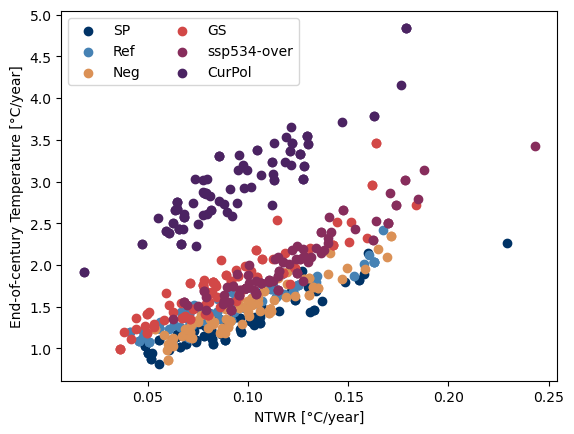

In [183]:
plt.figure()
for scen in cset.focus_scenarios: 
    scen_runs = [scen + '_' + str(i) for i in range(1,101)]
    plt.scatter(gmt_char_df.loc[scen_runs, 'gmt_ntwr'].values,
                gmt_char_df.loc[scen_runs, 'gmt_eoc'].values, 
                color = focus_scenarios_color_dict[scen],
                label = scen)
plt.legend(ncols = 2)
plt.xlabel('NTWR [°C/year]')
plt.ylabel('End-of-century Temperature [°C/year]')
plt.show()

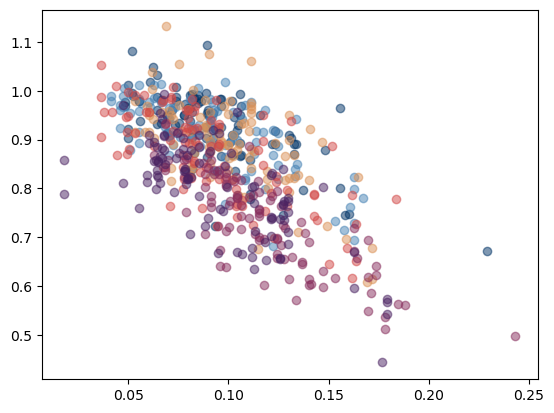

In [187]:
plt.figure()
for scen in cset.focus_scenarios: 
    scen_runs = [scen + '_' + str(i) for i in range(1,101)]
    gmt_vals = gmt_char_df.loc[scen_runs, 'gmt_ntwr'].values
    plt.scatter(gmt_vals,
        burke_cumulative.loc[(nath_cumulative['scen'] == scen)].groupby('run')['diff_SSP2'].median(),
        color = focus_scenarios_color_dict[scen],
        label = scen,
        alpha = .5)
plt.show()

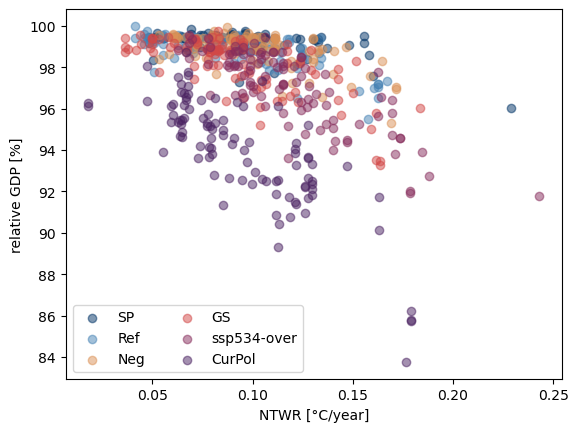

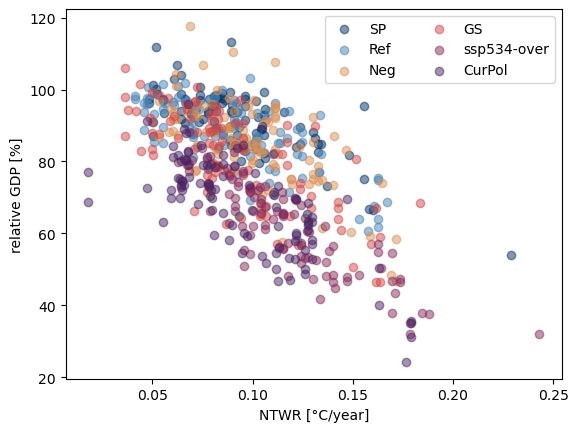

In [193]:
plt.figure()
for scen in cset.focus_scenarios: 
    scen_runs = [scen + '_' + str(i) for i in range(1,101)]
    gmt_vals = gmt_char_df.loc[scen_runs, 'gmt_ntwr'].values
    gdp_vals = nath_cumulative.loc[(nath_cumulative['scen'] == scen)].groupby('run')['diff_SSP2'].median()*100
    gdp_vals = nath_df.loc[(nath_df.year == 2090) & (nath_df.scen == scen)].groupby('run')['diff_SSP2'].median()*100
    plt.scatter(gmt_vals,
        gdp_vals,
        color = focus_scenarios_color_dict[scen],
        label = scen,
        alpha = .5)
plt.legend(ncols =2)
plt.xlabel('NTWR [°C/year]')
plt.ylabel('relative GDP [%]')
plt.show()

plt.figure()
for scen in cset.focus_scenarios: 
    scen_runs = [scen + '_' + str(i) for i in range(1,101)]
    gmt_vals = gmt_char_df.loc[scen_runs, 'gmt_ntwr'].values
    gdp_vals = burke_df.loc[(burke_df.year == 2090) & (burke_df.scen == scen)].groupby('run')['diff_SSP2'].median()*100
    plt.scatter(gmt_vals,
        gdp_vals,
        color = focus_scenarios_color_dict[scen],
        label = scen,
        alpha = .5)
plt.legend(ncols =2)
plt.xlabel('NTWR [°C/year]')
plt.ylabel('relative GDP [%]')
plt.show()


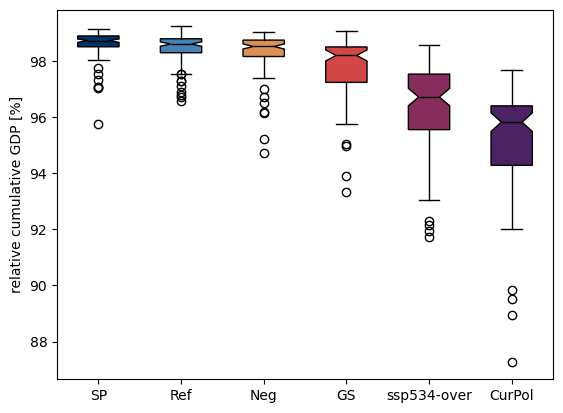

In [149]:
gdp_2100_df = nath_cumulative
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)
fig, ax = plt.subplots()
bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
        patch_artist = True, zorder = 10)
for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
ax.set_xticks(np.arange(1, len(cset.focus_scenarios) + 1), 
              labels = focus_scenarios)
ax.set_ylabel('relative cumulative GDP [%]')
plt.show()

In [74]:
gdp_ref = nath_df[nath_df.scen == 'Ref'].copy()
gdp_neg = nath_df[nath_df.scen == 'Neg'].copy()
gdp_gs = nath_df[nath_df.scen == 'GS'].copy()

ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
gs_quantiles = np.quantile(gdp_gs[gdp_gs.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100

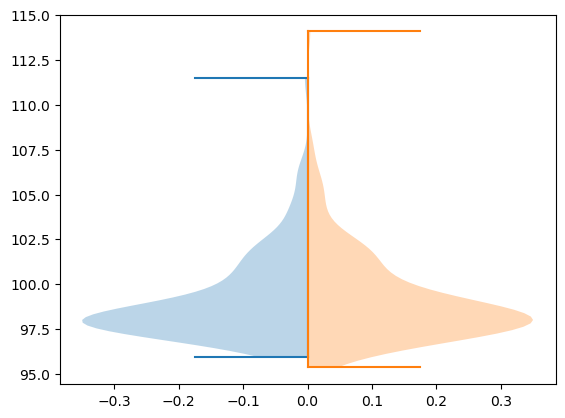

In [83]:
plt.figure()
year = 2085
width = 0.7
gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
# plt.hist(gdp_ref_tmp.values.flatten(), alpha= .5)
# plt.hist(gdp_neg_tmp.values.flatten(), alpha = .5)
plt.violinplot(gdp_ref_tmp.values.flatten(), [0], side = 'low', widths = width,)
plt.violinplot(gdp_neg_tmp.values.flatten(), [0], side = 'high', widths = width)
plt.show()

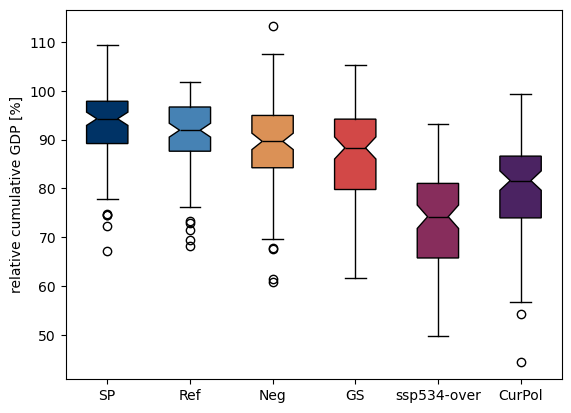

In [150]:
gdp_2100_df = burke_cumulative
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)
fig, ax = plt.subplots()
bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
        patch_artist = True, zorder = 10)
for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
ax.set_xticks(np.arange(1, len(cset.focus_scenarios) + 1), 
              labels = focus_scenarios)
ax.set_ylabel('relative cumulative GDP [%]')
plt.show()

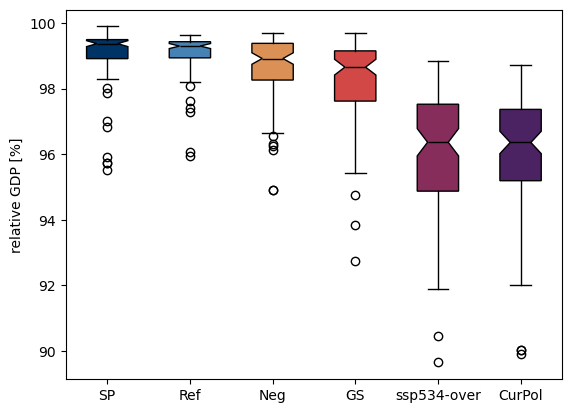

In [12]:
gdp_2100_df = nath_df.loc[nath_df.year == 2070]
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)
fig, ax = plt.subplots()
bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
        patch_artist = True, zorder = 10)
for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
ax.set_xticks(np.arange(1, len(cset.focus_scenarios) + 1), 
              labels = focus_scenarios)
ax.set_ylabel('relative GDP [%]')
plt.show()

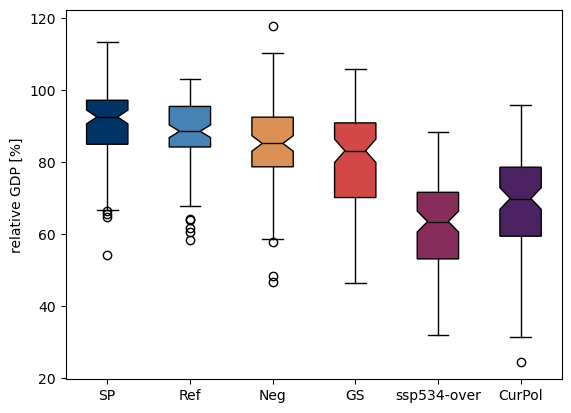

In [147]:
gdp_2100_df = burke_df.loc[burke_df.year == 2090]
# boxplot data
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q
    
f = {'diff_SSP2': [q_at(q) for q in [0.05,0.1,0.5,0.9,0.95]]}

boxplot_arr = []
for scen in cset.focus_scenarios:
    boxplot_arr.append(gdp_2100_df[gdp_2100_df.scen == scen].groupby('run').agg(f).loc[:, 'diff_SSP2'].values)
boxplot_arr = np.array(boxplot_arr)
fig, ax = plt.subplots()
bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
        patch_artist = True, zorder = 10)
for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
ax.set_xticks(np.arange(1, len(cset.focus_scenarios) + 1), 
              labels = focus_scenarios)
ax.set_xticks(np.arange(1, len(cset.focus_scenarios) + 1), 
              labels = focus_scenarios)
ax.set_ylabel('relative GDP [%]')
plt.show()

In [ ]:
from matplotlib.legend_handler import HandlerTuple
country_offset = [0] + [1] + [0] + [-1] + [1] + [0] + [-1]
impact_offset  = [0] + [0.01] + [-0.002] + [-0.035]*3
ls = (0, (5, 1))
axes = []
with sns.axes_style('whitegrid'): 
        fig = plt.figure(figsize=(20, 12))
        gs  = GridSpec(18, 14, figure=fig)

        ### PANEL A ####
        # - add boxplot:
        ax = fig.add_subplot(gs[1:8,:6])
        bplot = ax.boxplot((boxplot_arr[:, :, 2]).T*100, notch = True, 
                patch_artist = True, zorder = 10)
        for patch, color in zip(bplot['boxes'], focus_scenarios_color_dict.values()):
                patch.set_facecolor(color)
                patch.set_edgecolor('black')
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bplot[element], color='black')
        ax.set_xticks(np.arange(1, 1+cset.n_focus_scenarios),
                      focus_scenarios_labels, 
                        fontsize=labelsize_medium)
        ax.set_yticks([25,50,75,100,125],
                       [25,50,75,100,125],
                        fontsize=labelsize_medium)
        ax.set_ylim(10,140)
        ax.set_xlim(0.4, cset.n_focus_scenarios+0.6)
        ax.set_ylabel(r'GDP relative to baseline [%]', 
                      fontsize=labelsize_large) 
        ax.set_title('Median GDP per capita in 2100 across countries', 
                     fontsize = labelsize_large)   
        ax.text(0.4,142,'a',fontsize = labelsize_large, fontweight = 'bold') 
        # - add a secondary y axis for GMT values
        ax2 = ax.twinx()
        ax2.invert_yaxis()
        ax2.set_ylim(3.3, 0.7)
        ax2.set_yticks([1,1.5,2,2.5,3], 
                       [1,1.5,2,2.5,3],
                       fontsize = labelsize_medium)
        ax2.grid(axis='y', color='white', alpha=0)
        EOC = []
        MAX = []
        for i in range(cset.n_focus_scenarios):
            scatter_eoc = ax2.scatter(i+1+0.32, 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(focus_scenarios[i])].values[-1,:].mean(), 
                        color = focus_scenarios_colors[i], 
                        marker = '*',
                        s = 150,
                        label = ''
                        )
            scatter_max = ax2.scatter(i+1+0.45, 
                        gmt_ds.loc[:, gmt_ds.columns.str.contains(focus_scenarios[i])].values[:,:].max(axis = 0).mean(), 
                        color = focus_scenarios_colors[i], 
                        marker = 'o',
                        s = 150,
                        label = ''
                        )
            EOC.append(scatter_eoc)
            MAX.append(scatter_max)
        ax2.set_ylabel('Temperature [°C]', 
                       fontsize = labelsize_medium,
                       rotation = 270,
                       labelpad = 20)
        ax2.legend([(EOC[0], EOC[1], EOC[2], EOC[3], EOC[4], EOC[5]), 
                    (MAX[0], MAX[1], MAX[2], MAX[3], MAX[4], MAX[5])], 
                   ['2100 GMT', 'Maximum GMT'], 
                   handlelength=2,
                   handler_map={tuple: HandlerTuple(ndivide=None)},
                   fontsize = labelsize_medium, 
                   loc = 'upper right', 
                   frameon = False)
        axes.append(ax)
        

In [151]:
# estimate GDP development 
def q1(x):
    return x.quantile(0.1)
def q9(x):
    return x.quantile(0.9)

def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)
# derive differences
gdp_ref = burke_df[burke_df.scen == 'Ref'].copy()
gdp_neg = burke_df[burke_df.scen == 'Neg'].copy()
gdp_gs = burke_df[burke_df.scen == 'GS'].copy()

# derive timeseries of of 10th, median and 90th percentile: 
f = {'diff_SSP2': ['median', 'std', q1, q9, q05, q95]}
gdp_ref_agg = gdp_ref.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()
gdp_neg_agg = gdp_neg.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()

ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
gs_quantiles = np.quantile(gdp_gs[gdp_gs.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100

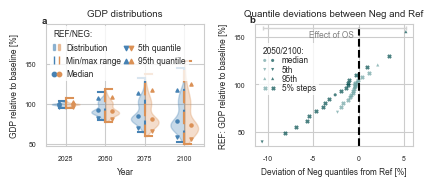

In [156]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgba
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11/2.54, 5/2.54))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 5, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 5, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Distribution', 'Min/max range', 'Median', '5th quantile', '95th quantile']
    ax.legend(new_handles, 
              new_labels, 
              loc = 'upper left', 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                handlelength = .75,
                ncol = 2,
                title = 'REF/NEG:', 
                title_fontsize = labelsize_medium,
                alignment = 'left',
                bbox_to_anchor = (0, 1.02),
                columnspacing = 0.5,
                )
    ax.set_xlim(-0.5,3.5)
    ax.set_ylim(48, 199)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([50,100,150],[50,100,150], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 201, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 5, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 5, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 5, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 5, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 5, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['median', '5th', '95th', f'5% steps']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of Neg quantiles from Ref [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([50,100,150], 
                  [50,100,150],
                  fontsize = labelsize_small)
    ax.set_xticks([-10,-5,0,5], 
                  [-10,-5,0,5], 
                  fontsize = labelsize_small)
    ax.legend(new_handles, new_labels, loc = 'upper left',
              bbox_to_anchor = (0, 0.88), 
                fontsize = labelsize_medium, 
                edgecolor = 'none',
                facecolor = [1,1,1,0.7], 
                handler_map={tuple: HandlerTuple(ndivide=None)},
                ncol = 1, 
                columnspacing = 0.7,
                labelspacing = 0.01,
                handlelength = 1.5,
                title = '2050/2100:',
                title_fontsize = labelsize_medium,
                alignment = 'left')
    ax.set_title('Quantile deviations between Neg and Ref',
                 fontsize = labelsize_large)
    ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    ax.plot([-10.5,5.2], [159,159], color = 'lightgrey', linestyle = '-', lw = 1)
    ax.scatter([5.2], [159],  marker = '|', s = 10, color = 'lightgrey', lw = 1)
    ax.scatter([-10.5], [159],  marker = '|', s = 10, color = 'lightgrey', lw = 1)
    ax.text( -3, 152,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey')
    ax.set_ylim(35,163)
    plt.tight_layout()
    plt.show()


In [157]:
# estimate GDP development 
def q1(x):
    return x.quantile(0.1)
def q9(x):
    return x.quantile(0.9)

def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)
# derive differences
gdp_ref = nath_df[nath_df.scen == 'Ref'].copy()
gdp_neg = nath_df[nath_df.scen == 'Neg'].copy()
gdp_gs = nath_df[nath_df.scen == 'GS'].copy()

# derive timeseries of of 10th, median and 90th percentile: 
f = {'diff_SSP2': ['median', 'std', q1, q9, q05, q95]}
gdp_ref_agg = gdp_ref.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()
gdp_neg_agg = gdp_neg.loc[:, ['year', 'diff_SSP2']].groupby('year').agg(f).loc[:, 'diff_SSP2'].copy()

ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
gs_quantiles = np.quantile(gdp_gs[gdp_gs.year == 2100].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100

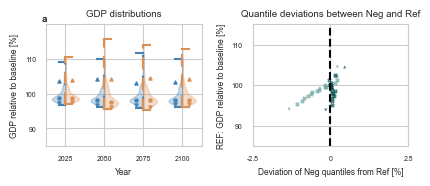

In [170]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.colors import to_rgba
colors = sns.color_palette("blend:#B6DADA,#004D4D", as_cmap=True)(np.linspace(0.4,1,2))
symbols = ['s', 'X', 'o', 'D']
width = 0.7
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 2, figsize=(11/2.54, 5/2.54))
    ax = axes[0]
    edge_colors = [focus_scenarios_color_dict['Ref'], focus_scenarios_color_dict['Neg']]
    face_colors = [to_rgba(color, 0.7) for color in edge_colors]
    for i_year, year in enumerate([2025, 2050,2075,2100]):
        gdp_ref_tmp = gdp_ref[gdp_ref.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_neg_tmp = gdp_neg[gdp_neg.year == year].loc[:, ['iso', 'diff_SSP2']].groupby('iso').median()*100
        gdp_ref_tmp = gdp_ref_tmp[gdp_ref_tmp.values <= 1.1*gdp_ref_tmp.quantile(.99).values[0]]
        gdp_neg_tmp = gdp_neg_tmp[gdp_neg_tmp.values <= 1.1*gdp_neg_tmp.quantile(.99).values[0]]
        # ax.violinplot(np.array([gdp_ref_tmp.values.flatten(), gdp_neg_tmp.values.flatten()]).T,
        #               showmedians=True, quantiles= [[0.05, 0.1, 0.9, 0.95],[0.05, 0.1, 0.9, 0.95]]
        #               )
        pc_ref = ax.violinplot(gdp_ref_tmp.values.flatten(), [i_year], side = 'low', widths = width,)
        pc_neg = ax.violinplot(gdp_neg_tmp.values.flatten(), [i_year], side = 'high', widths = width)
        
        pos_ref = i_year-width/4
        pos_neg = i_year+width/4
        
        for i_q, q in enumerate([0.05,0.5,0.95]): 
            ax.scatter([pos_ref], np.quantile(gdp_ref_tmp.values.flatten(), q = q), s = 5, marker = ['v', 'o', '^'][i_q], color = edge_colors[0])
            ax.scatter([pos_neg], np.quantile(gdp_neg_tmp.values.flatten(), q = q), s = 5, marker = ['v', 'o', '^'][i_q], color = edge_colors[1])
        
        for pc in pc_ref['bodies']:
            pc.set_facecolor(face_colors[0])
            pc.set_edgecolor(edge_colors[0])
        for pc in pc_neg['bodies']:
            pc.set_facecolor(face_colors[1])
            pc.set_edgecolor(edge_colors[1])
        for prop in ['cmins', 'cmaxes', 'cbars']:
            for i_scen, pc in enumerate([pc_ref, pc_neg]):
                pc[prop].set_color(edge_colors[i_scen])
                if prop in ['cmedians']:
                    pc[prop].set_linewidth(2)
                if prop in ['cbars']:
                    pc[prop].set_linestyle((0, (5, 5)))
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Ref'], alpha = .5, label = 'Ref')
    ax.fill_between([-1], [0], [0], color = focus_scenarios_color_dict['Neg'], alpha = .5, label = 'Neg')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Ref'], label = 'Ref')
    ax.plot([-1, -1], [0, 0], marker = '|', linestyle = '', color = focus_scenarios_color_dict['Neg'], label = 'Neg')
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = 'o', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = 'v', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Ref'], label = 'Ref', s = 10)
    ax.scatter([-1],[0], marker = '^', color = focus_scenarios_color_dict['Neg'], label = 'Neg', s = 10)
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [tuple([handles[i] for i in range(j*2, (j+1)*2)]) for j in range(5)]
    new_labels = ['Distribution', 'Min/max range', 'Median', '5th quantile', '95th quantile']
    # ax.legend(new_handles, 
    #           new_labels, 
    #           loc = 'upper left', 
    #             fontsize = labelsize_medium, 
    #             edgecolor = 'none',
    #             facecolor = [1,1,1,0.7], 
    #             handler_map={tuple: HandlerTuple(ndivide=None)},
    #             handlelength = .75,
    #             ncol = 2,
    #             title = 'REF/NEG:', 
    #             title_fontsize = labelsize_medium,
    #             alignment = 'left',
    #             bbox_to_anchor = (0, 1.02),
    #             columnspacing = 0.5,
    #             )
    ax.set_xlim(-0.5,3.5)
    ax.set_ylim(85, 120)
    ax.set_xticks([0,1,2, 3], ['2025', '2050', '2075', '2100'], fontsize = labelsize_small)
    ax.set_yticks([90,100,110],[90,100,110], fontsize = labelsize_small)  
    ax.set_ylabel('GDP relative to baseline [%]', 
                    fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_medium)
    ax.text(-0.6, 121, 'a', fontsize = labelsize_large, fontweight = 'bold')
    ax.set_title('GDP distributions', 
                 fontsize = labelsize_large)
    
    ax = axes[1]
    
    for i, year in enumerate([2050,2100]):
        ref_quantiles = np.quantile(gdp_ref[gdp_ref.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        neg_quantiles = np.quantile(gdp_neg[gdp_neg.year == year].loc[:, 'diff_SSP2'].values.flatten(), q = np.arange(0.05, 1, 0.05))*100
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[0], 
                   ref_quantiles[0], 
                   s = 5, 
                   marker = 'v', 
                   alpha  = .7, 
                   edgecolor = 'none',
                   facecolor = colors[i],
                   label = '5th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[-1], 
                   ref_quantiles[-1], 
                s = 5, 
                marker = '^', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = '95th')
        ax.scatter(((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[9], 
                ref_quantiles[9], 
                s = 5, 
                marker = 'o', 
                alpha  = .7, 
                edgecolor = 'none',
                facecolor = colors[i],
                label = 'median')
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[1:9], 
                ref_quantiles[1:9], 
                s = 5, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i], 
                label = year)
        ax.scatter(
                ((neg_quantiles-ref_quantiles)/(ref_quantiles)*100)[10:-1], 
                ref_quantiles[10:-1], 
                s = 5, 
                marker = 'x', 
                alpha  = .7, 
                facecolor = colors[i])
    handles, labels = ax.get_legend_handles_labels()
    median_handles = tuple([handles[i] for i in [2, 6]])
    lower_handles = tuple([handles[i] for i in [0, 4]])
    upper_handles = tuple([handles[i] for i in [1, 5]])
    quantile_handles = tuple([handles[i] for i in [3, 7]])
    new_handles =  [median_handles, lower_handles, upper_handles, quantile_handles] 
    # + [tuple([handles[i] for i in range(j*4, (j+1)*4)]) for j in range(3)]
    new_labels = ['median', '5th', '95th', f'5% steps']
    
    ax.axvline(0, color = 'black', linestyle = '--')
    ax.set_ylabel('REF: GDP relative to baseline [%]',
                  fontsize = labelsize_medium)
    ax.set_xlabel('Deviation of Neg quantiles from Ref [%]', 
                  fontsize = labelsize_medium)
    ax.set_yticks([90,100,110], 
                  [90,100,110],
                  fontsize = labelsize_small)
    ax.set_xticks([-2.5,0,2.5], 
                  [-2.5,0,2.5], 
                  fontsize = labelsize_small)
    # ax.legend(new_handles, new_labels, loc = 'upper left',
    #           bbox_to_anchor = (0, 0.88), 
    #             fontsize = labelsize_medium, 
    #             edgecolor = 'none',
    #             facecolor = [1,1,1,0.7], 
    #             handler_map={tuple: HandlerTuple(ndivide=None)},
    #             ncol = 1, 
    #             columnspacing = 0.7,
    #             labelspacing = 0.01,
    #             handlelength = 1.5,
    #             title = '2050/2100:',
    #             title_fontsize = labelsize_medium,
    #             alignment = 'left')
    ax.set_title('Quantile deviations between Neg and Ref',
                 fontsize = labelsize_large)
    # ax.text(-12,165, 'b', fontsize = labelsize_large, fontweight = 'bold')
    # ax.plot([-10.5,5.2], [159,159], color = 'lightgrey', linestyle = '-', lw = 1)
    # ax.scatter([5.2], [159],  marker = '|', s = 10, color = 'lightgrey', lw = 1)
    # ax.scatter([-10.5], [159],  marker = '|', s = 10, color = 'lightgrey', lw = 1)
    # ax.text( -3, 152,  'Effect of OS', fontsize = labelsize_medium, rotation = 0, va = 'center', ha = 'center', color = 'grey')
    ax.set_ylim(85,115)
    plt.tight_layout()
    plt.show()